<a href="https://colab.research.google.com/github/KateT840/Laboratorio_moderna/blob/main/Lab_2/Codigo_Lab_2_mercurio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import os
from google.colab import drive
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [25]:
os.chdir("/content/drive/MyDrive/Laboratorio_moderna/Lab2/")
!ls

 Espectro_H.csv      'Interpolación cuadrática para Mg.png'
 espectros_H_Mg.png   Linea_amarilla_del_Mer.csv
 Esprectro_Mer.csv


In [26]:
file = '/content/drive/MyDrive/Laboratorio_moderna/Lab2/Esprectro_Mer.csv'
file

'/content/drive/MyDrive/Laboratorio_moderna/Lab2/Esprectro_Mer.csv'

In [27]:
df = pd.read_csv(file)

In [28]:
df = pd.read_csv(file, sep=',', decimal='.', header=None)
df.columns = ['Distance_(pixels)', 'Gray_Value']

print(df.head())
print(df.dtypes)

   Distance_(pixels)  Gray_Value
0  Distance_(pixels)  Gray_Value
1                  0     185.000
2                  1     188.065
3                  2     198.129
4                  3     198.097
Distance_(pixels)    object
Gray_Value           object
dtype: object


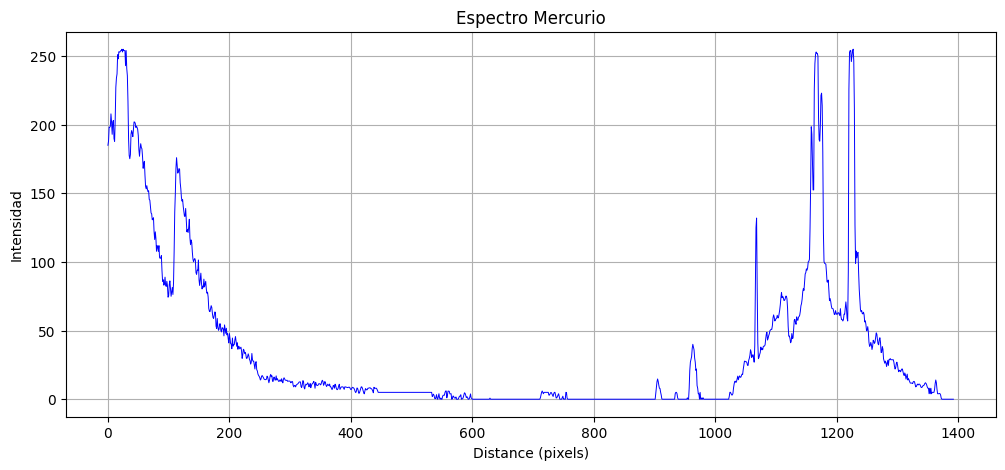

In [29]:
# Asegurar que las columnas sean numéricas
df["Distance_(pixels)"] = pd.to_numeric(df["Distance_(pixels)"], errors="coerce")
df["Gray_Value"] = pd.to_numeric(df["Gray_Value"], errors="coerce")
df = df.dropna()

# --- Graficar espectro Mg (sin invertir) ---
x = df["Distance_(pixels)"].values
y = df["Gray_Value"].values

plt.figure(figsize=(12,5))
plt.plot(x, y, linewidth=0.7, color="blue")
plt.xlabel("Distance (pixels)")
plt.ylabel("Intensidad")
plt.title("Espectro Mercurio")
plt.grid(True)
plt.show()

Primer pico en el rango 0–200 píxeles:
Pixel = 23.0, Intensidad = 255.0


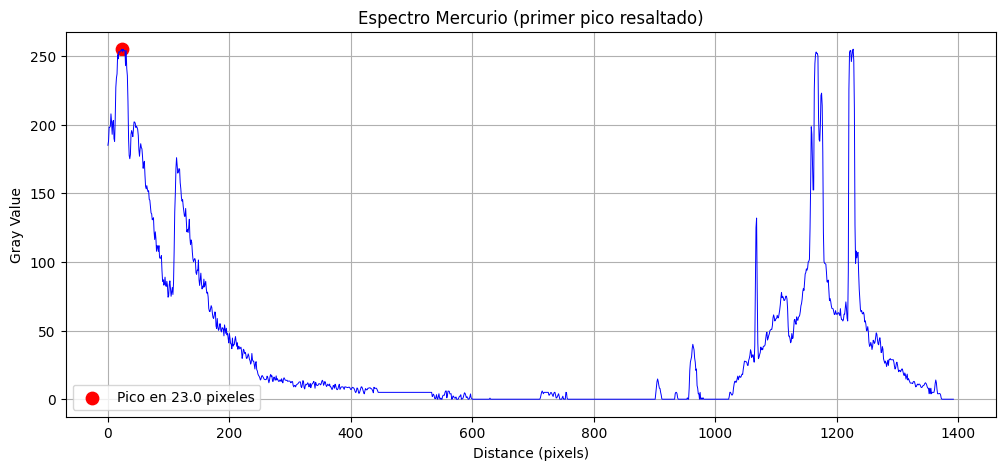

In [30]:
# Filtrar el rango 0–200 píxeles directamente
sub_df = df[(df["Distance_(pixels)"] >= 0) & (df["Distance_(pixels)"] <= 200)]

# Encontrar el máximo
max_idx = sub_df["Gray_Value"].idxmax()
pico_x = sub_df.loc[max_idx, "Distance_(pixels)"]
pico_y = sub_df.loc[max_idx, "Gray_Value"]

print(f"Primer pico en el rango 0–200 píxeles:")
print(f"Pixel = {pico_x}, Intensidad = {pico_y}")

# Graficar con el pico resaltado
plt.figure(figsize=(12,5))
plt.plot(df["Distance_(pixels)"], df["Gray_Value"], linewidth=0.7, color="blue")
plt.scatter(pico_x, pico_y, color="red", s=80, label=f"Pico en {pico_x:.1f} pixeles")
plt.xlabel("Distance (pixels)")
plt.ylabel("Gray Value")
plt.title("Espectro Mercurio (primer pico resaltado)")
plt.legend()
plt.grid(True)
plt.show()


   Línea   Pixel  Δpix desde fuente  Intensidad
0      1   963.0              940.0      40.000
1      2  1068.0             1045.0     132.000
2      3  1109.0             1086.0      77.851
3      4  1166.0             1143.0     253.000
4      5  1227.0             1204.0     255.000


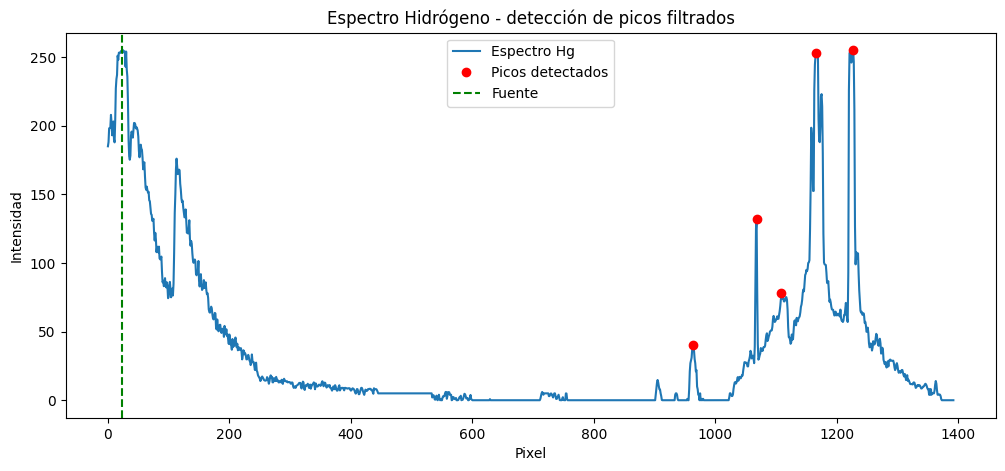

In [31]:
x_fuente = 23.0

# --- Buscar picos con parámetros más suaves ---
peaks, props = find_peaks(
    y,
    prominence=20,   # ajusta según tu espectro
    distance=10
)

# --- Filtrar: descartar rango 1000–1200 y todo lo que esté antes de 500 ---
valid_peaks = [
    p for p in peaks
    if (x[p] >= 500)]

# Datos de los picos válidos
pix_lines = x[valid_peaks]
delta_pix = pix_lines - x_fuente
intensity = y[valid_peaks]

resultados = pd.DataFrame({
    "Línea": range(1, len(valid_peaks)+1),
    "Pixel": pix_lines,
    "Δpix desde fuente": delta_pix,
    "Intensidad": intensity
}).sort_values("Δpix desde fuente")

print(resultados)

# Gráfico
plt.figure(figsize=(12,5))
plt.plot(x, y, label="Espectro Hg")
plt.plot(pix_lines, intensity, "ro", label="Picos detectados")
plt.axvline(x_fuente, color="g", linestyle="--", label="Fuente")
plt.xlabel("Pixel")
plt.ylabel("Intensidad")
plt.title("Espectro Hidrógeno - detección de picos filtrados")
plt.legend()
plt.show()

   Línea   Pixel  Δpix desde fuente  Intensidad
0      1   963.0              940.0      40.000
1      2  1068.0             1045.0     132.000
2      3  1109.0             1086.0      77.851
3      4  1166.0             1143.0     253.000
4      5  1222.0             1199.0     254.000
5      6  1227.0             1204.0     255.000


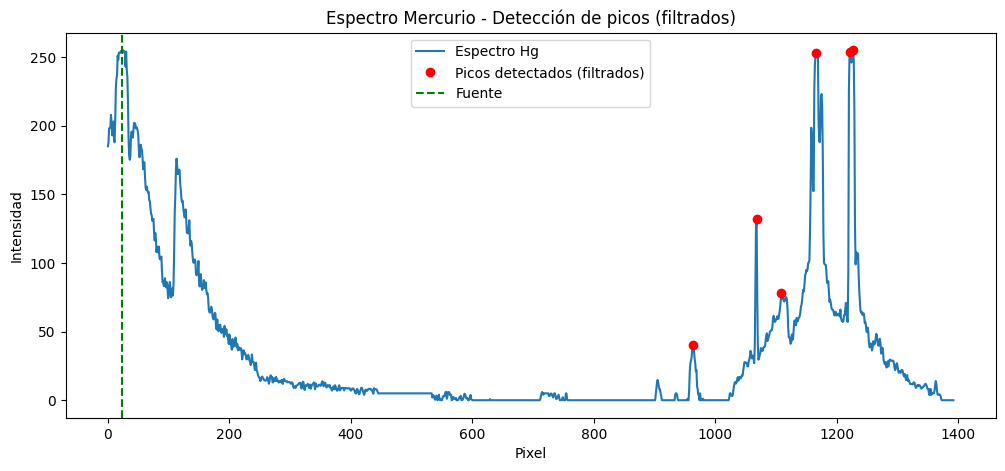

In [32]:
x_fuente = 23.0

# --- Picos globales ---
peaks, props = find_peaks(
    y,
    prominence=20,
    distance=10
)

valid_peaks = [p for p in peaks if (x[p] >= 500)]

# --- Picos extra en la zona 1200–1300 ---
mask = (x >= 1200) & (x <= 1300)
x_zoom, y_zoom = x[mask], y[mask]

peaks_zoom, props_zoom = find_peaks(
    y_zoom,
    prominence=5,
    distance=2
)

peaks_zoom_global = np.where(mask)[0][peaks_zoom]

# --- Combinar picos ---
all_peaks = np.unique(np.concatenate([valid_peaks, peaks_zoom_global]))

pix_lines = x[all_peaks]
delta_pix = pix_lines - x_fuente
intensity = y[all_peaks]

# --- Eliminar picos indeseados ---
pix_excluir = [1206, 1215, 1232, 1265, 1271, 1288]
mask_keep = ~np.isin(pix_lines, pix_excluir)

pix_lines = pix_lines[mask_keep]
delta_pix = delta_pix[mask_keep]
intensity = intensity[mask_keep]

# --- Tabla resultados ---
resultados = pd.DataFrame({
    "Línea": range(1, len(pix_lines)+1),
    "Pixel": pix_lines,
    "Δpix desde fuente": delta_pix,
    "Intensidad": intensity
}).sort_values("Δpix desde fuente")

print(resultados)

# --- Gráfico ---
plt.figure(figsize=(12,5))
plt.plot(x, y, label="Espectro Hg")
plt.plot(pix_lines, intensity, "ro", label="Picos detectados (filtrados)")
plt.axvline(x_fuente, color="g", linestyle="--", label="Fuente")
plt.xlabel("Pixel")
plt.ylabel("Intensidad")
plt.title("Espectro Mercurio - Detección de picos (filtrados)")
plt.legend()
plt.show()


Ecuación de calibración: λ = 0.715 * pixel + -282.346
R² = 0.9556


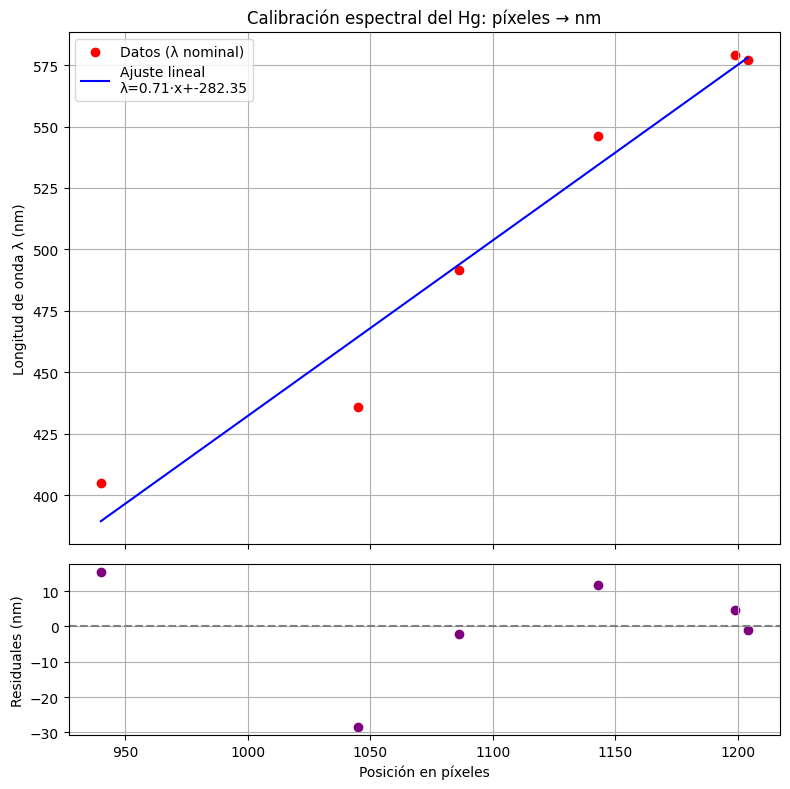

In [33]:
#Gráfica longitud de onda y pixeles con regresión lineal
# === 1. Datos experimentales (pixeles y λ nominales) ===
pixeles = np.array([1204.0, 1199.0, 1143.0, 1086.0, 1045.0, 940.0])     # píxeles de tus picos
lambdas = np.array([576.96, 579.07, 546.1, 491.6, 435.8, 404.7])  # λ nominales (nm)

# === 2. Ajuste lineal ===
X = pixeles.reshape(-1, 1)
y = lambdas
modelo = LinearRegression().fit(X, y)

pendiente = modelo.coef_[0]
intercepto = modelo.intercept_
R2 = modelo.score(X, y)

print(f"Ecuación de calibración: λ = {pendiente:.3f} * pixel + {intercepto:.3f}")
print(f"R² = {R2:.4f}")

# === 3. Predicciones y residuales ===
y_pred = modelo.predict(X)
residuales = y - y_pred

# === 4. Gráficas ===
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True,
                               gridspec_kw={'height_ratios':[3,1]})

# (a) Ajuste principal
ax1.scatter(pixeles, lambdas, color="red", label="Datos (λ nominal)")
ax1.plot(pixeles, y_pred, color="blue", label=f"Ajuste lineal\nλ={pendiente:.2f}·x+{intercepto:.2f}")
ax1.set_ylabel("Longitud de onda λ (nm)")
ax1.set_title("Calibración espectral del Hg: píxeles → nm")
ax1.legend()
ax1.grid(True)

# (b) Residuales
ax2.scatter(pixeles, residuales, color="purple")
ax2.axhline(0, color="gray", linestyle="--")
ax2.set_xlabel("Posición en píxeles")
ax2.set_ylabel("Residuales (nm)")
ax2.grid(True)

plt.tight_layout()
plt.show()


0.001049327060613262 -1.5481639942383076 927.8758367996645
Ecuación cuadrática ajustada (LaTeX style):
$\lambda(x) = + 1.05 \times 10^{-3} x^2 - 1.55 x + 9.28 \times 10^{2}$
R² (cuadrático) = 0.969460


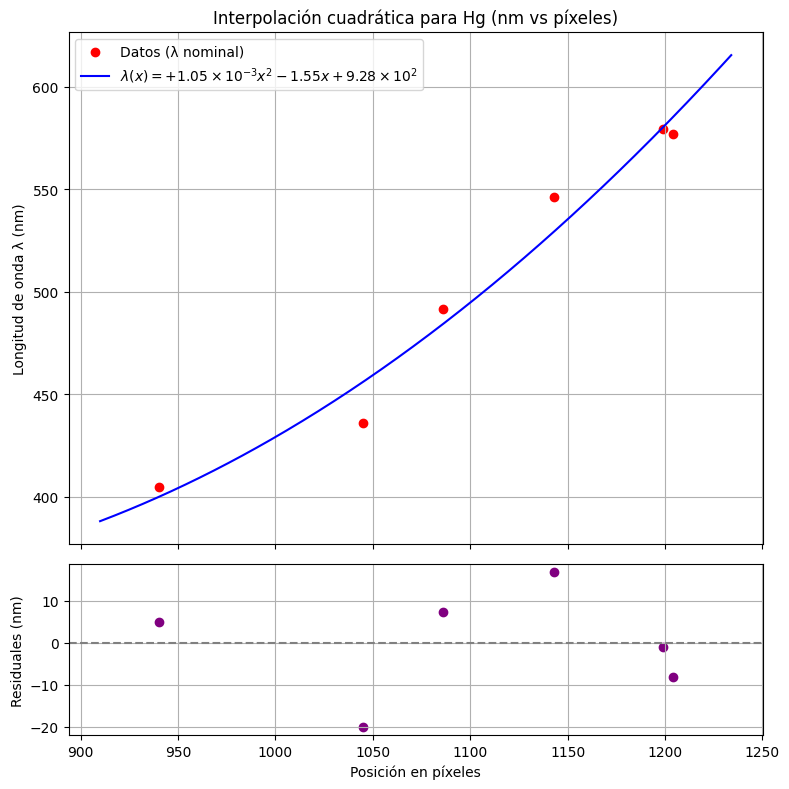

pixel 1204.0 -> λ_quad = 585.008 nm (valor nominal: 576.960 nm)
pixel 1199.0 -> λ_quad = 580.141 nm (valor nominal: 579.070 nm)
pixel 1143.0 -> λ_quad = 529.217 nm (valor nominal: 546.100 nm)
pixel 1086.0 -> λ_quad = 484.142 nm (valor nominal: 491.600 nm)
pixel 1045.0 -> λ_quad = 455.936 nm (valor nominal: 435.800 nm)
pixel 940.0 -> λ_quad = 399.787 nm (valor nominal: 404.700 nm)


In [34]:
#Gráfica longitud de onda y pixeles con regresión cuadrática
# --- Tus datos ---
pixeles = np.array([1204.0, 1199.0, 1143.0, 1086.0, 1045.0, 940.0])     # píxeles de tus picos
lambdas = np.array([576.96, 579.07, 546.1, 491.6, 435.8, 404.7])  # λ nominales (nm)

# --- Ajuste cuadrático ---
coef = np.polyfit(pixeles, lambdas, 2)  # [a, b, c]
a, b, c = coef
print(a,b,c)

# Función para notación 10^n tipo LaTeX sin mostrar 10^0
def format_coeff(x):
    s = f"{abs(x):.2e}"   # base positiva
    base, exp = s.split("e")
    sign = "-" if x < 0 else "+"
    exp = int(exp)
    if exp == 0:
        return sign, f"{float(base):.2f}"  # solo el número
    else:
        return sign, f"{base} \\times 10^{{{exp}}}"

# Obtener signos y valores
sign_a, val_a = format_coeff(a)
sign_b, val_b = format_coeff(b)
sign_c, val_c = format_coeff(c)

# Mostrar ecuación bonita
print("Ecuación cuadrática ajustada (LaTeX style):")
eq_str = f"$\\lambda(x) = {sign_a} {val_a} x^2 {sign_b} {val_b} x {sign_c} {val_c}$"
print(eq_str)

# --- Predicciones y R² ---
p = np.poly1d(coef)
y_fit = p(pixeles)
ss_res = np.sum((lambdas - y_fit)**2)
ss_tot = np.sum((lambdas - np.mean(lambdas))**2)
R2 = 1 - ss_res/ss_tot
print(f"R² (cuadrático) = {R2:.6f}")

# --- Residuales ---
residuales = lambdas - y_fit

# --- Gráficas ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True,
                               gridspec_kw={'height_ratios':[3,1]})

xs = np.linspace(pixeles.min()-30, pixeles.max()+30, 400)
ys = p(xs)

ax1.scatter(pixeles, lambdas, color='red', label='Datos (λ nominal)')
ax1.plot(xs, ys, color='blue', label=eq_str)
ax1.set_ylabel("Longitud de onda λ (nm)")
ax1.set_title("Interpolación cuadrática para Hg (nm vs píxeles)")
ax1.legend()
ax1.grid(True)

ax2.scatter(pixeles, residuales, color="purple")
ax2.axhline(0, color="gray", linestyle="--")
ax2.set_xlabel("Posición en píxeles")
ax2.set_ylabel("Residuales (nm)")
ax2.grid(True)

plt.tight_layout()
plt.savefig("Interpolación cuadrática para Hg.png", dpi=300, bbox_inches="tight")
plt.show()

# --- Función de conversión ---
def pixel_to_lambda_quad(x_pixel):
    return a*x_pixel**2 + b*x_pixel + c

# Ejemplo
for px in pixeles:
    print(f"pixel {px:.1f} -> λ_quad = {pixel_to_lambda_quad(px):.3f} nm "
          f"(valor nominal: {lambdas[np.where(pixeles==px)][0]:.3f} nm)")

In [35]:


from google.colab import files
files.download("Interpolación cuadrática para Hg.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>